<a href="https://colab.research.google.com/github/rahulrajpr/learning/blob/main/TensorFlowDeveloperCertifcateTraining/TensorFlowDeveloperCertifcateTraining-main/06.NLP/fundamentals.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import os
import random
import warnings 
warnings.filterwarnings('ignore')

In [2]:
!nvidia-smi -L

NVIDIA-SMI has failed because it couldn't communicate with the NVIDIA driver. Make sure that the latest NVIDIA driver is installed and running.



In [3]:
# get the helper functions

!wget https://raw.githubusercontent.com/rahulrajpr/references/main/helper_functions.py

--2023-02-26 16:26:35--  https://raw.githubusercontent.com/rahulrajpr/references/main/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 11994 (12K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  11.71K  --.-KB/s    in 0s      

2023-02-26 16:26:36 (75.3 MB/s) - ‘helper_functions.py’ saved [11994/11994]



In [4]:
from helper_functions import unzip_data,plot_loss_curves,compare_historys

In [5]:
!wget https://storage.googleapis.com/ztm_tf_course/nlp_getting_started.zip

unzip_data('nlp_getting_started.zip')

--2023-02-26 16:26:36--  https://storage.googleapis.com/ztm_tf_course/nlp_getting_started.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 172.253.62.128, 172.253.122.128, 142.251.111.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|172.253.62.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 607343 (593K) [application/zip]
Saving to: ‘nlp_getting_started.zip’

nlp_getting_started 100%[===================>] 593.11K  --.-KB/s    in 0.007s  

2023-02-26 16:26:36 (87.1 MB/s) - ‘nlp_getting_started.zip’ saved [607343/607343]



lets read the dataset using tha pandas

In [6]:
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')

train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


Lets shufflet the dataframe

In [7]:
train_df = train_df.sample(frac = 1.0, random_state = 42).reset_index(drop = True)

In [8]:
train_df.head(3)

,id,keyword,location,text,target
0,3796,destruction,NaN,So you have a new weapon that can cause un-ima...,1
1,3185,deluge,NaN,The f$&amp;@ing things I do for #GISHWHES Just...,0
2,7769,police,UK,DT @georgegalloway: RT @Galloway4Mayor: ÛÏThe...,1


In [9]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3263 entries, 0 to 3262
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        3263 non-null   int64 
 1   keyword   3237 non-null   object
 2   location  2158 non-null   object
 3   text      3263 non-null   object
dtypes: int64(1), object(3)
memory usage: 102.1+ KB


The test dataframe does not have any lables associated with it,we need to create a validation set out of the train df

Lets randomly inspect some of the samples from the train dataset

In [10]:
start_index = random.randint(0, len(train_df)-5)
index_range = range(start_index, start_index+5)

for ind in index_range:
  tweat = train_df.iloc[ind]['text']
  label = train_df.iloc[ind]['target']
  class_name = 'Disaster' if label == 1 else 'Not a disaster'
  print(f"""{class_name} : 
  
        {tweat}
        
        ----------
        """)

Disaster : 
  
        Japan Marks 70th Anniversary of Hiroshima Atomic Bombing http://t.co/93vqkdFgnr
        
        ----------
        
Disaster : 
  
        Correction: Tent Collapse Story http://t.co/jXs50FkviK
        
        ----------
        
Disaster : 
  
        @Arovolturi3000 survived because of magic  she is searching the wood for survivors outside of London
        
        ----------
        
Not a disaster : 
  
        I'm about to be obliterated
        
        ----------
        
Not a disaster : 
  
        I ruin everything ????
        
        ----------
        


lets create a validation set out of the train set

In [11]:
from sklearn.model_selection import train_test_split

In [12]:
X = train_df['text'].to_numpy()
y = train_df['target'].to_numpy()

In [13]:
train_sentance, val_sentance,train_label, val_label = train_test_split(X,y,test_size = 0.1, random_state = 42, stratify = y)

In [14]:
len(train_sentance), len(val_sentance), len(train_label), len(val_label)

(6851, 762, 6851, 762)

In [15]:
train_sentance[:5], train_label[:5]

(array(['BBC News - India rail crash: Trains derail in Madhya Pradesh flash flood http://t.co/wmUTCDG36b',
        '@Ohmygoshi @unsuckdcmetro At this point I expect to hear reports about a Metrobus being derailed.',
        'Cramer: 3 words that wrecked DIS stock - http://t.co/ud7XObYUa1',
        "China's Stock Market Crash: Are There Gems In The Rubble? http://t.co/o6oNSjHCsD #tcot #p2 #news",
        'Heard theres two more deaths and a murder chrissie kills adam?  val and finn die? #emmerdale'],
       dtype=object), array([1, 1, 0, 0, 0]))

In [16]:
val_sentance[:5], val_label[:5]

(array(['Maaaaan I love Love Without Tragedy by @rihanna I wish she made the whole song',
        '?Ìü New Ladies Shoulder Tote #Handbag Faux Leather Hobo Purse Cross Body Bag #Womens http://t.co/UooZXauS26 http://t.co/Pw78nblJKy RT en\x89Û_',
        "@noah_anyname That's where the concentration camps and mass murder come in. \n \nEVERY. FUCKING. TIME.",
        "Sinkhole Selfies: You Wont Believe What's In The Brooklyn Sinkhole!: \n        Sinkhole Sel... http://t.co/OYY9MGW7HN @hinterestin #funny",
        'California wildfires force thousands to evacuate: http://t.co/GFsl2Kwt5h via @YouTube'],
       dtype=object), array([0, 0, 0, 0, 1]))

### lets converst our sentances into learnable numbers

- Tokenization (creating direct integer mapping of the sentances)

- Embedding - (creating richer respresntation learnibale relationship of words in the sentances)

Before move further, lers fix some parameters from the training data

In [17]:
# lets understand the length of each senatances

sentance_length = [len(x.split()) for x in train_sentance]

sentance_length[:5]

[14, 15, 9, 14, 16]

In [18]:
optimum_sentance_length = round(np.mean(sentance_length))
optimum_sentance_length

15

In [19]:
# lets fix a number of unique words we care to put forwards

optimum_unique_words = 10000

> Lets Tokenize out input santances

In [20]:
text_tokenizer = tf.keras.layers.TextVectorization(max_tokens = optimum_unique_words,
                                                   standardize = 'lower_and_strip_punctuation',
                                                   ngrams = None,
                                                   output_mode = 'int',
                                                   output_sequence_length= optimum_sentance_length)

text_tokenizer

In [21]:
text_tokenizer.adapt(train_sentance)

In [22]:
text_tokenizer.vocabulary_size()

10000

In [23]:
learned_vocs = text_tokenizer.get_vocabulary()
learned_vocs[:10]

['', '[UNK]', 'the', 'a', 'in', 'to', 'of', 'and', 'i', 'is']

In [24]:
top_5_vocs = learned_vocs[:5]
least_5_vocs = learned_vocs[-5:]

In [25]:
top_5_vocs

['', '[UNK]', 'the', 'a', 'in']

In [26]:
least_5_vocs

['papicongress', 'papi', 'paperwork', 'paperback', 'papcrdoll']

> lets see how the toekenizer instance works on the random samples

In [27]:
random_sample = random.choice(train_sentance)

random_sample_tokenized = text_tokenizer([random_sample])

print(f'Random sample \n\n{random_sample}\n')
print(f"Tokenized Representation\n\n{random_sample_tokenized}\n")
print(f"Tokenized shape:{random_sample_tokenized.shape} ,\n\nTokenized Type : {type(random_sample_tokenized)}")

Random sample 

@APPLEOFFIClAL Migrating from iPhoto to Photo is a catastrophe. I have wasted days trying to get this to work. 12 hrsto get to 8% complete.

Tokenized Representation

[[   1    1   20    1    5  313    9    3  371    8   24 6874  576  689
     5]]

Tokenized shape:(1, 15) ,

Tokenized Type : <class 'tensorflow.python.framework.ops.EagerTensor'>


In here the sentances have been converted to tokens of integers with defined parameter for the tekenization object

> Lets do the Embegging so that the tokenized object can be learned in realation with the other tokens

In [28]:
embedding = tf.keras.layers.Embedding(input_dim = optimum_unique_words,
                                      output_dim = 128,
                                      input_length = optimum_sentance_length)

Lets do a random sentance tranfoemation

In [29]:
random_sample = random.choice(train_sentance)

tokenized_random_sample = text_tokenizer([random_sample])

embedded_sample = embedding(tokenized_random_sample)

print(f"Random sample :\n\n{random_sample}")
print(f'\n\nTokenized shape : {tokenized_random_sample.shape}\n\nTokenized sample :\n\n{tokenized_random_sample}')
print(f"\n\nEmbedded Sample Shape : {embedded_sample.shape}\n\nEmbedded Sample :\n\n{embedded_sample}")

Random sample :

@Catwoman1775 Another shooting in a movie theater this is getting more crazier but I'm glad they got the shooter &amp; no casualties.


Tokenized shape : (1, 15)

Tokenized sample :

[[   1  164  564    4    3  244  984   19    9  230   53    1   30   33
  1142]]


Embedded Sample Shape : (1, 15, 128)

Embedded Sample :

[[[ 1.6983971e-03  1.6839396e-02  1.0392822e-02 ... -3.9175272e-02
   -4.5413792e-02 -1.2864698e-02]
  [-1.2246609e-02 -3.1223333e-02 -1.7990340e-02 ... -3.6224999e-02
    1.5451048e-02  6.7404881e-03]
  [-8.1914775e-03 -1.4543749e-02 -4.7763634e-02 ... -3.5308469e-02
   -2.6730478e-02  4.4068310e-02]
  ...
  [ 5.6120157e-03  4.1867424e-02  3.2880042e-02 ...  3.6759797e-02
    3.2624710e-02  9.0539828e-03]
  [ 3.9199699e-02  4.8760775e-02  3.2356605e-03 ... -2.1046162e-02
   -2.4171360e-03  2.3022477e-02]
  [ 7.0251822e-03 -8.3726160e-03  2.8760459e-02 ... -2.1345913e-06
    4.7663186e-02 -4.1294336e-02]]]


In here the embedding is converting the each token (total 15 tokens in a sentance as defined) into 128 weight elements, which represents the relationship betweem the tokens in a sentance

### Setting up the Experiments 


    Model 0: Naive Bayes (baseline) - got this from here: https://scikit-learn.org/stable/tutorial/machine_learning_map/index.html
    Model 1: Feed-forward neural network (dense model)
    Model 2: LSTM model
    Model 3: GRU model
    Model 4: Bidirectional LSTM
    Model 5: 1D Convolutional Neural Network
    Model 6: TensorFlow Hub Pretrained Word Embedding (feature extractor)
    Model 7: Same as model 6 but using 10% of data


# Lets create the Naive Base Model (Base Line) using sklearn with ITidf Vectorisation from sklearn

In [30]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

In [31]:
# create the machine leraning pipeline for Multinominal Naive Base

%%time

model_0 = Pipeline(steps = [('vetorisation',TfidfVectorizer()),
                         ('classification', MultinomialNB())])

model_0.fit(train_sentance,train_label)

CPU times: user 267 ms, sys: 3.96 ms, total: 271 ms
Wall time: 317 ms


Pipeline(steps=[('vetorisation', TfidfVectorizer()),
                ('classification', MultinomialNB())])

In [32]:
model_0.score(val_sentance,val_label)

0.8136482939632546

> 81.36% is the baseline score to beat

lets look at the other classification metrics

In [33]:
pred_0 = model_0.predict(val_sentance)
pred_0[:10]

array([0, 0, 0, 1, 1, 1, 0, 0, 1, 1])

In [34]:
from helper_functions import calculate_results

In [35]:
result_0 = calculate_results(y_true = val_label, y_pred = pred_0)

result_0

{'accuracy': 0.8136482939632546,
 'precision': 0.8252309148353214,
 'recall': 0.8136482939632546,
 'f1': 0.8079226106150957}

# Model 1 : Feed Forward Dence Nueral Networks

In [36]:
# create a tensorboard callback

from helper_functions import create_tensorboard_callback

SAVE_DIR = 'model_logs'

In [37]:
from tensorflow.keras import layers
from tensorflow.keras.optimizers import Adam

In [38]:
# lets build our model

inputs = layers.Input(shape = (1,), dtype = tf.string, name = 'input_layer')

x = text_tokenizer(inputs)

x = embedding(x)

x = layers.GlobalAveragePooling1D()(x)

outputs = layers.Dense(units = 1, activation = 'sigmoid' ,name = 'output_layer')(x)

model_1 = tf.keras.Model(inputs,outputs, name = 'model_1')

model_1.compile(loss = 'binary_crossentropy',
                optimizer = Adam(),
                metrics = ['accuracy'])

In [39]:
model_1.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 1)]               0         
                                                                 
 text_vectorization (TextVec  (None, 15)               0         
 torization)                                                     
                                                                 
 embedding (Embedding)       (None, 15, 128)           1280000   
                                                                 
 global_average_pooling1d (G  (None, 128)              0         
 lobalAveragePooling1D)                                          
                                                                 
 output_layer (Dense)        (None, 1)                 129       
                                                                 
Total params: 1,280,129
Trainable params: 1,280,129
Non-tra

In [40]:
# lets fit the model

history_1 = model_1.fit(x = train_sentance,
                        y = train_label,
                        epochs = 5,
                        validation_data = (val_sentance, val_label),
                        callbacks = [create_tensorboard_callback(dir_name = SAVE_DIR,
                                                                 experiment_name = 'model_1_dense')])

Saving TensorBoard log files to: model_logs/model_1_dense/20230226-162639
Epoch 1/5
215/215 [==============================] - 5s 18ms/step - loss: 0.6116 - accuracy: 0.6876 - val_loss: 0.5250 - val_accuracy: 0.7822
Epoch 2/5
215/215 [==============================] - 3s 16ms/step - loss: 0.4421 - accuracy: 0.8178 - val_loss: 0.4561 - val_accuracy: 0.8097
Epoch 3/5
215/215 [==============================] - 4s 19ms/step - loss: 0.3478 - accuracy: 0.8594 - val_loss: 0.4388 - val_accuracy: 0.8110
Epoch 4/5
215/215 [==============================] - 3s 15ms/step - loss: 0.2862 - accuracy: 0.8878 - val_loss: 0.4380 - val_accuracy: 0.8005
Epoch 5/5
215/215 [==============================] - 3s 15ms/step - loss: 0.2393 - accuracy: 0.9123 - val_loss: 0.4507 - val_accuracy: 0.8031


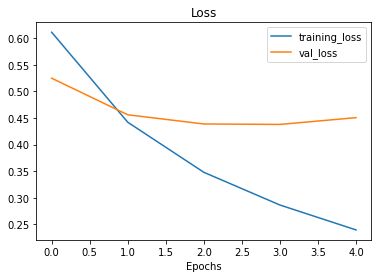

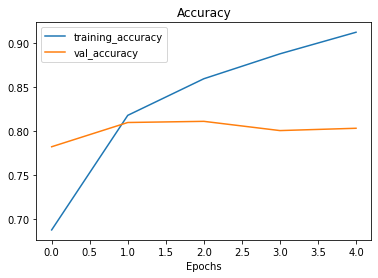

In [41]:
plot_loss_curves(history_1)

In [42]:
model_1.evaluate(val_sentance, val_label)

24/24 [==============================] - 0s 2ms/step - loss: 0.4507 - accuracy: 0.8031


[0.4507233202457428, 0.8031495809555054]

In [43]:
pred_1_prob = model_1.predict(val_sentance)
pred_1_prob.shape

24/24 [==============================] - 0s 2ms/step


(762, 1)

In [44]:
pred_1_prob[:10]

array([[0.00990751],
       [0.016647  ],
       [0.7351458 ],
       [0.73328495],
       [0.9145198 ],
       [0.37604636],
       [0.750362  ],
       [0.04925439],
       [0.9271803 ],
       [0.9555373 ]], dtype=float32)

In [45]:
pred_1 = np.round(tf.squeeze(pred_1_prob))
pred_1[:10]

array([0., 0., 1., 1., 1., 0., 1., 0., 1., 1.], dtype=float32)

Lets look at the model results

In [46]:
result_1 = calculate_results(y_true = val_label, y_pred = pred_1)
result_1

{'accuracy': 0.8031496062992126,
 'precision': 0.8030697298796085,
 'recall': 0.8031496062992126,
 'f1': 0.8014539281290952}

In [47]:
result_0

{'accuracy': 0.8136482939632546,
 'precision': 0.8252309148353214,
 'recall': 0.8136482939632546,
 'f1': 0.8079226106150957}

# Visualizing the word embeddings

In [48]:
model_1.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 1)]               0         
                                                                 
 text_vectorization (TextVec  (None, 15)               0         
 torization)                                                     
                                                                 
 embedding (Embedding)       (None, 15, 128)           1280000   
                                                                 
 global_average_pooling1d (G  (None, 128)              0         
 lobalAveragePooling1D)                                          
                                                                 
 output_layer (Dense)        (None, 1)                 129       
                                                                 
Total params: 1,280,129
Trainable params: 1,280,129
Non-tra

Get the weights from the embedding the layer in the learned model

In [49]:
name_embedding_layer = model_1.layers[2].name

In [50]:
embedding_weights = model_1.get_layer(name_embedding_layer).get_weights()[0]
embedding_weights

array([[-0.00761866, -0.01170841,  0.03755645, ..., -0.03751459,
         0.05560588,  0.01654021],
       [-0.00468691,  0.02102679,  0.0058193 , ..., -0.04013372,
        -0.03821853, -0.00929882],
       [-0.0707007 ,  0.05662023, -0.01510392, ..., -0.03369612,
         0.05104033, -0.0024436 ],
       ...,
       [-0.06921231,  0.03465649, -0.00355914, ..., -0.07457151,
        -0.00816534,  0.03301853],
       [ 0.00141313,  0.01259816, -0.01502256, ..., -0.0471774 ,
         0.06392597,  0.01728498],
       [-0.06721896,  0.00471282, -0.03286519, ..., -0.0805697 ,
         0.06126313,  0.03888468]], dtype=float32)

In [51]:
vocabulory = text_tokenizer.get_vocabulary()
vocabulory[:5]

['', '[UNK]', 'the', 'a', 'in']

Create TSV files to upload to https://projector.tensorflow.org/

In [52]:
# to download the files for embedding projection

import io

# Code to save trained embeddings to file - we got this from here: https://www.tensorflow.org/tutorials/text/word_embeddings#retrieve_the_trained_word_embeddings_and_save_them_to_disk
out_v = io.open('vectors.tsv', 'w', encoding='utf-8')
out_m = io.open('metadata.tsv', 'w', encoding='utf-8')

for index, word in enumerate(vocabulory):
  if index == 0:
    continue  # skip 0, it's padding.
  vec = embedding_weights[index]
  out_v.write('\t'.join([str(x) for x in vec]) + "\n")
  out_m.write(word + "\n")
out_v.close()
out_m.close()

Lets download to upload to https://projector.tensorflow.org/

In [53]:
# Let's download the saved embeddings locally
try:
  from google.colab import files
  files.download('vectors.tsv')
  files.download('metadata.tsv')
except Exception:
  pass

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Here is the output we obtained from the website

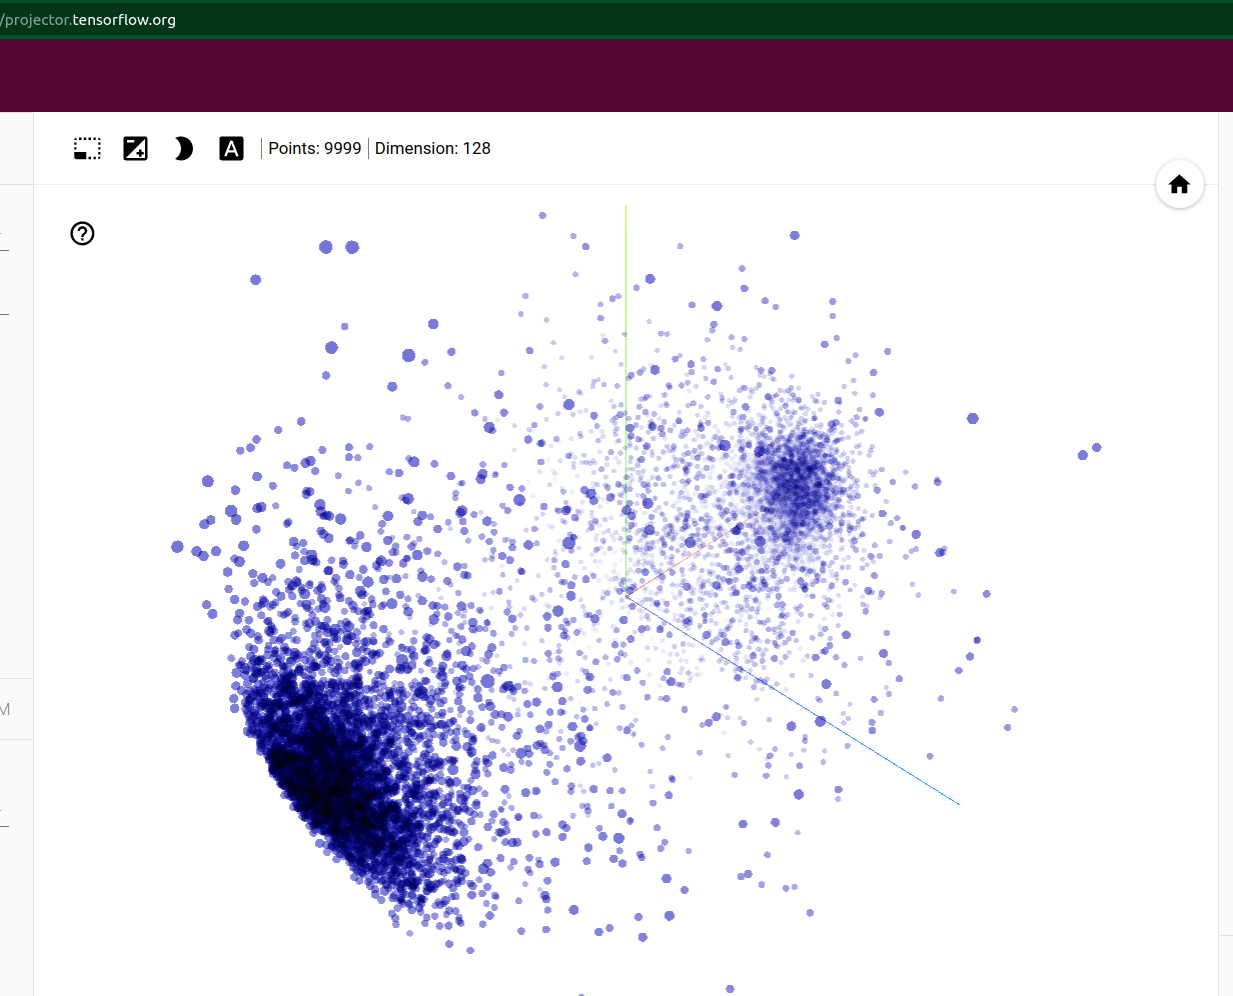

# Model 2 : RNN - LSTM

- RNN - Reccurring Nueral Network

- LSTM - Long Short-Term Memory

Architecture of LSTM in text classification Problem

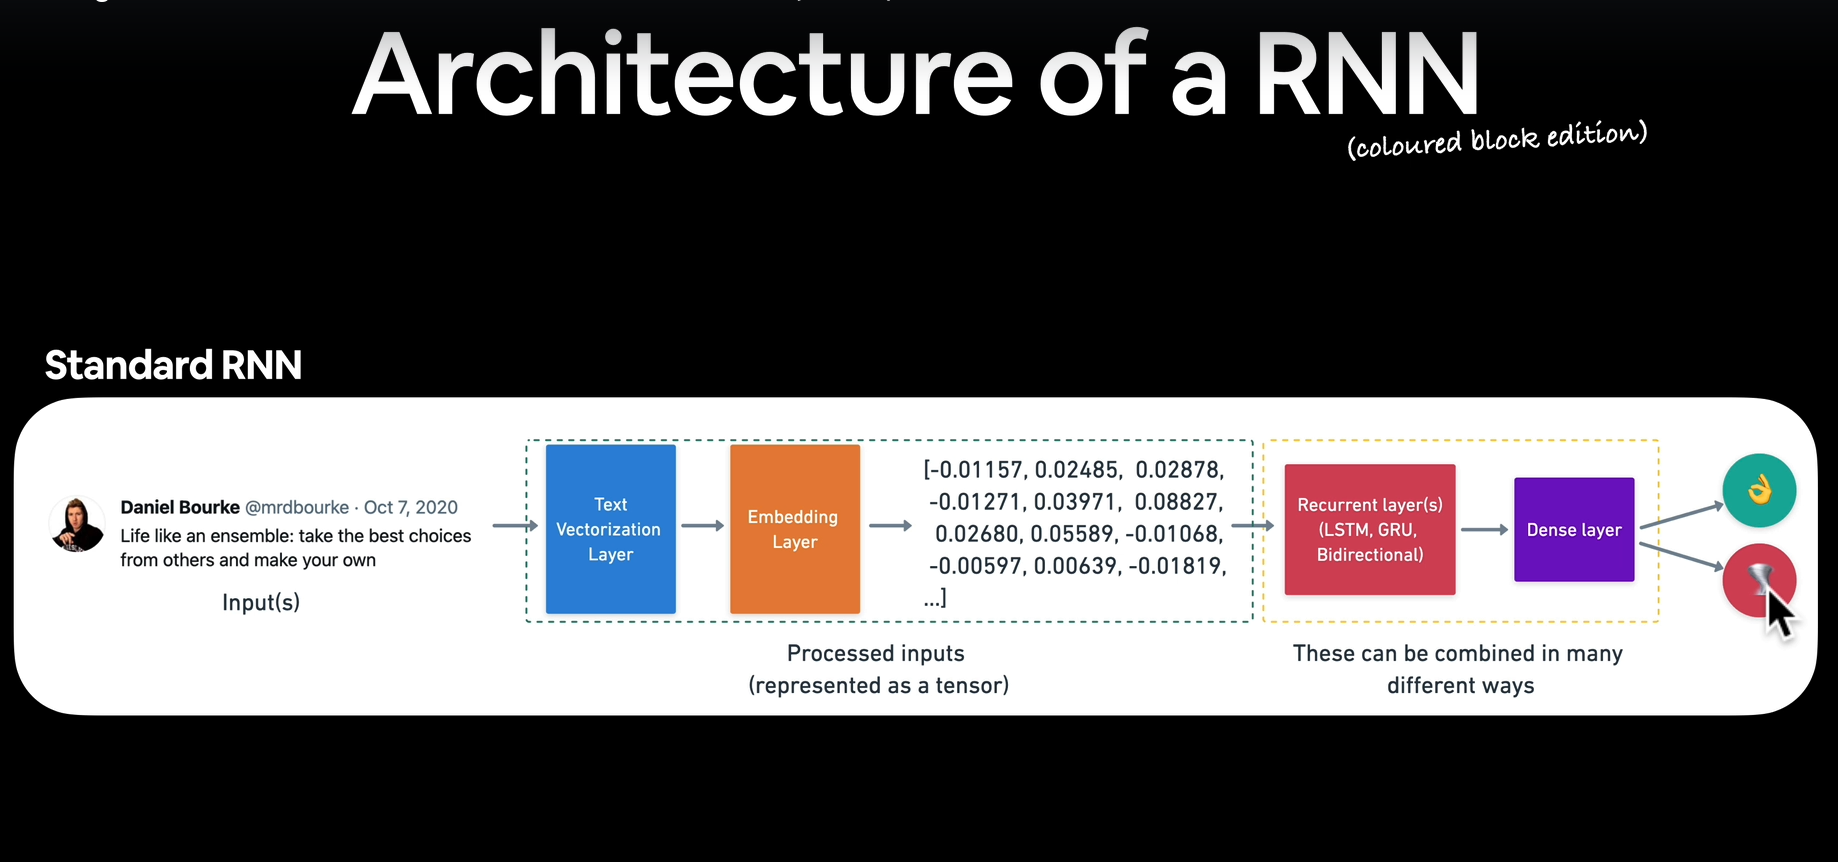

In [54]:
# create the LSTM RNN Model

inputs = layers.Input(shape = (1,), dtype = tf.string, name = 'input_layer')

x = text_tokenizer(inputs)

x = embedding(x)

print(x.shape)

x = layers.LSTM(units = 64, activation = 'tanh')(x)

print(x.shape)

outputs = layers.Dense(units =1, activation = 'sigmoid')(x)

print(outputs.shape)

model_2 = tf.keras.Model(inputs,outputs, name = 'model_2_LSTM')

(None, 15, 128)
(None, 64)
(None, 1)


In [55]:
# lets compile the model

model_2.compile(loss = 'binary_crossentropy',
                optimizer = Adam(),
                metrics = ['accuracy'])

In [56]:
# lets fit the model

history_2 = model_2.fit(x = train_sentance,
                        y = train_label,
                        epochs = 5,
                        validation_data = (val_sentance,val_label),
                        callbacks = [create_tensorboard_callback(SAVE_DIR,'model_2_LSTM')])

Saving TensorBoard log files to: model_logs/model_2_LSTM/20230226-162701
Epoch 1/5
215/215 [==============================] - 10s 32ms/step - loss: 0.2190 - accuracy: 0.9242 - val_loss: 0.4993 - val_accuracy: 0.7927
Epoch 2/5
215/215 [==============================] - 7s 33ms/step - loss: 0.1554 - accuracy: 0.9404 - val_loss: 0.6505 - val_accuracy: 0.7874
Epoch 3/5
215/215 [==============================] - 6s 28ms/step - loss: 0.1255 - accuracy: 0.9518 - val_loss: 0.6194 - val_accuracy: 0.7782
Epoch 4/5
215/215 [==============================] - 7s 34ms/step - loss: 0.1046 - accuracy: 0.9628 - val_loss: 0.7815 - val_accuracy: 0.7743
Epoch 5/5
215/215 [==============================] - 6s 30ms/step - loss: 0.0850 - accuracy: 0.9672 - val_loss: 0.7489 - val_accuracy: 0.7730


In [57]:
result_2 = model_2.evaluate(val_sentance,val_label)
result_2

24/24 [==============================] - 0s 6ms/step - loss: 0.7489 - accuracy: 0.7730


[0.7489244937896729, 0.7729659080505371]

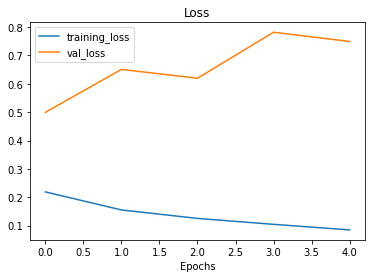

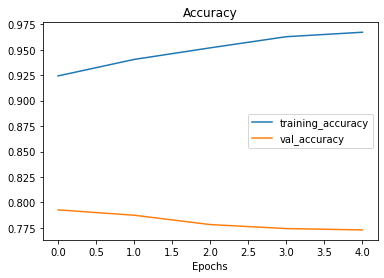

In [58]:
plot_loss_curves(history_2)

In [59]:
pred_2_prob = model_2.predict(val_sentance)
pred_2_prob[:10]

24/24 [==============================] - 1s 4ms/step


array([[0.00477931],
       [0.11407472],
       [0.5754702 ],
       [0.678051  ],
       [0.98751444],
       [0.02859513],
       [0.85852325],
       [0.00118106],
       [0.99864525],
       [0.99499893]], dtype=float32)

In [60]:
pred_2 = tf.squeeze(tf.round(pred_2_prob))

pred_2[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 0., 1., 1., 1., 0., 1., 0., 1., 1.], dtype=float32)>

In [61]:
result_2 = calculate_results(val_label,pred_2)
result_2

{'accuracy': 0.7729658792650919,
 'precision': 0.7722757649683181,
 'recall': 0.7729658792650919,
 'f1': 0.7709374681327572}

Modifying the model2 with one More LSTM Layer to chcek whether the model performs better

In [62]:
# create the LSTM RNN Model -(Modified Version)

inputs = layers.Input(shape = (1,), dtype = tf.string, name = 'input_layer')

x = text_tokenizer(inputs)

x = embedding(x)

print(x.shape)

x = layers.LSTM(units = 64, activation = 'tanh', return_sequences= True)(x) # An LSTM / RNN only takes a sequence as an input, 

# hence it is import to retun the precedding LSTM/RNN outputs as sequence if you are feeding into another RNN/LSTM

# RNN layers retuns a feature vector by deafult rather than returning a sequence

print(x.shape)

x = layers.LSTM(units = 64)(x)

print(x.shape)

outputs = layers.Dense(units =1, activation = 'sigmoid')(x)

print(outputs.shape)

model_2_modified = tf.keras.Model(inputs,outputs, name = 'model_2_LSTM')

(None, 15, 128)
(None, 15, 64)
(None, 64)
(None, 1)


In [63]:
# lets compile the model

model_2_modified.compile(loss = 'binary_crossentropy',
                         optimizer = Adam(),
                         metrics = ['accuracy'])

In [64]:
# lets fit the model

history_2_modified = model_2_modified.fit(x = train_sentance,
                                          y = train_label,
                                          epochs = 5,
                                          validation_data = (val_sentance,val_label),
                                          callbacks = [create_tensorboard_callback(SAVE_DIR,'model_2_LSTM')])

Saving TensorBoard log files to: model_logs/model_2_LSTM/20230226-162746
Epoch 1/5
215/215 [==============================] - 16s 52ms/step - loss: 0.1382 - accuracy: 0.9527 - val_loss: 0.8332 - val_accuracy: 0.7297
Epoch 2/5
215/215 [==============================] - 9s 44ms/step - loss: 0.0753 - accuracy: 0.9712 - val_loss: 0.9272 - val_accuracy: 0.7612
Epoch 3/5
215/215 [==============================] - 9s 43ms/step - loss: 0.0627 - accuracy: 0.9749 - val_loss: 0.9476 - val_accuracy: 0.7533
Epoch 4/5
215/215 [==============================] - 8s 38ms/step - loss: 0.0526 - accuracy: 0.9764 - val_loss: 1.1684 - val_accuracy: 0.7782
Epoch 5/5
215/215 [==============================] - 9s 44ms/step - loss: 0.0462 - accuracy: 0.9788 - val_loss: 1.3622 - val_accuracy: 0.7730


In [65]:
model_2_modified.evaluate(val_sentance)

24/24 [==============================] - 1s 2ms/step - loss: 0.0000e+00 - accuracy: 0.0000e+00


[0.0, 0.0]

In [66]:
pred_2_modified_prob = model_2_modified.predict(val_sentance)

pred_2_modified_prob[:10]

24/24 [==============================] - 1s 8ms/step


array([[8.2891161e-04],
       [2.4297556e-01],
       [9.9902493e-01],
       [9.2553967e-01],
       [9.9991888e-01],
       [1.6796498e-03],
       [9.9583417e-01],
       [9.8678378e-05],
       [9.9994528e-01],
       [9.9992949e-01]], dtype=float32)

In [67]:
pred_2_modified = tf.squeeze(tf.round(pred_2_modified_prob))
pred_2_modified[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 0., 1., 1., 1., 0., 1., 0., 1., 1.], dtype=float32)>

In [68]:
result_2_modified = calculate_results(val_label,pred_2_modified)
result_2_modified

{'accuracy': 0.7729658792650919,
 'precision': 0.7721608383247476,
 'recall': 0.7729658792650919,
 'f1': 0.7723349202915246}

# Model 3 : RNN with GRU cell

In [69]:
inputs = tf.keras.Input(shape = (1,), dtype = tf.string, name = 'input_layer')

x = text_tokenizer(inputs)

x = embedding(x)

x = layers.GRU(units = 64, activation = 'tanh')(x)

outputs = layers.Dense(units = 1, activation = 'sigmoid', name = 'output_layer')(x)

model_3 = tf.keras.Model(inputs, outputs, name = 'model_3_GRU')

In [70]:
model_3.compile(loss = 'binary_crossentropy',
                optimizer = Adam(), 
                metrics = ['accuracy'])

In [71]:
history_3 = model_3.fit(train_sentance,
                        train_label,
                        epochs = 5,
                        validation_data = (val_sentance,val_label),
                        callbacks = [create_tensorboard_callback(SAVE_DIR, 'model_3_GRU')])

Saving TensorBoard log files to: model_logs/model_3_GRU/20230226-162841
Epoch 1/5
215/215 [==============================] - 11s 34ms/step - loss: 0.1398 - accuracy: 0.9464 - val_loss: 0.8476 - val_accuracy: 0.7690
Epoch 2/5
215/215 [==============================] - 7s 32ms/step - loss: 0.0642 - accuracy: 0.9764 - val_loss: 1.0253 - val_accuracy: 0.7690
Epoch 3/5
215/215 [==============================] - 6s 27ms/step - loss: 0.0469 - accuracy: 0.9771 - val_loss: 1.3168 - val_accuracy: 0.7690
Epoch 4/5
215/215 [==============================] - 7s 30ms/step - loss: 0.0486 - accuracy: 0.9777 - val_loss: 0.8006 - val_accuracy: 0.7651
Epoch 5/5
215/215 [==============================] - 5s 25ms/step - loss: 0.0455 - accuracy: 0.9790 - val_loss: 1.2068 - val_accuracy: 0.7598


In [72]:
model_3.evaluate(val_sentance)

24/24 [==============================] - 0s 2ms/step - loss: 0.0000e+00 - accuracy: 0.0000e+00


[0.0, 0.0]

In [73]:
pred_3_prob = model_3.predict(val_sentance)
pred_3_prob[:10]

24/24 [==============================] - 1s 4ms/step


array([[1.7269736e-03],
       [1.9677907e-01],
       [9.9723309e-01],
       [1.8106828e-02],
       [9.9969643e-01],
       [2.3171812e-02],
       [9.9799049e-01],
       [4.3461935e-04],
       [9.9990201e-01],
       [9.9970835e-01]], dtype=float32)

In [74]:
pred_3 = tf.squeeze(tf.round(pred_3_prob))
pred_3[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 0., 1., 0., 1., 0., 1., 0., 1., 1.], dtype=float32)>

In [75]:
result_3 = calculate_results(val_label, pred_3)
result_3

{'accuracy': 0.7598425196850394,
 'precision': 0.759753107703435,
 'recall': 0.7598425196850394,
 'f1': 0.7597964949517949}

# Model 4 : Bidirectional RNN

In [76]:
inputs = tf.keras.Input(shape = (1,), dtype = tf.string, name = 'input_layer')

x = text_tokenizer(inputs)

x = embedding(x)

x = layers.Bidirectional(layers.LSTM(units = 64))(x)

outputs = layers.Dense(units = 1, activation = 'sigmoid', name = 'output_layer')(x)

model_4 = tf.keras.Model(inputs,outputs, name = 'model_4_bidirectional')

In [77]:
model_4.summary()

Model: "model_4_bidirectional"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 1)]               0         
                                                                 
 text_vectorization (TextVec  (None, 15)               0         
 torization)                                                     
                                                                 
 embedding (Embedding)       (None, 15, 128)           1280000   
                                                                 
 bidirectional (Bidirectiona  (None, 128)              98816     
 l)                                                              
                                                                 
 output_layer (Dense)        (None, 1)                 129       
                                                                 
Total params: 1,378,945
Trainable params: 1,3

In [78]:
model_4.compile(loss = 'binary_crossentropy',
                optimizer = Adam(),
                metrics = ['accuracy'])

In [79]:
history_4 = model_4.fit(train_sentance,
                        train_label,
                        epochs = 5,
                        validation_data = (val_sentance, val_label),
                        callbacks = [create_tensorboard_callback(SAVE_DIR, 'model_4_bidirectional')])

Saving TensorBoard log files to: model_logs/model_4_bidirectional/20230226-162918
Epoch 1/5
215/215 [==============================] - 14s 41ms/step - loss: 0.0982 - accuracy: 0.9679 - val_loss: 1.1065 - val_accuracy: 0.7428
Epoch 2/5
215/215 [==============================] - 9s 41ms/step - loss: 0.0404 - accuracy: 0.9796 - val_loss: 1.1435 - val_accuracy: 0.7559
Epoch 3/5
215/215 [==============================] - 9s 43ms/step - loss: 0.0374 - accuracy: 0.9809 - val_loss: 1.3971 - val_accuracy: 0.7717
Epoch 4/5
215/215 [==============================] - 8s 37ms/step - loss: 0.0409 - accuracy: 0.9803 - val_loss: 1.4130 - val_accuracy: 0.7690
Epoch 5/5
215/215 [==============================] - 9s 43ms/step - loss: 0.0388 - accuracy: 0.9807 - val_loss: 1.4420 - val_accuracy: 0.7730


In [80]:
model_4.evaluate(val_sentance,val_label)

24/24 [==============================] - 0s 6ms/step - loss: 1.4420 - accuracy: 0.7730


[1.4420175552368164, 0.7729659080505371]

In [81]:
pred_4_prob = model_4.predict(val_sentance)
pred_4_prob[:10]

24/24 [==============================] - 1s 6ms/step


array([[2.5346302e-05],
       [2.0202175e-01],
       [9.8997706e-01],
       [1.8388219e-02],
       [9.9990106e-01],
       [1.7410103e-02],
       [8.4950143e-01],
       [2.5870169e-05],
       [9.9996465e-01],
       [9.9992383e-01]], dtype=float32)

In [82]:
pred_4 = tf.squeeze(tf.round(pred_4_prob))

pred_4[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 0., 1., 0., 1., 0., 1., 0., 1., 1.], dtype=float32)>

In [83]:
result_4 = calculate_results(val_label,pred_4)
result_4

{'accuracy': 0.7729658792650919,
 'precision': 0.771977762827624,
 'recall': 0.7729658792650919,
 'f1': 0.7717519050976827}

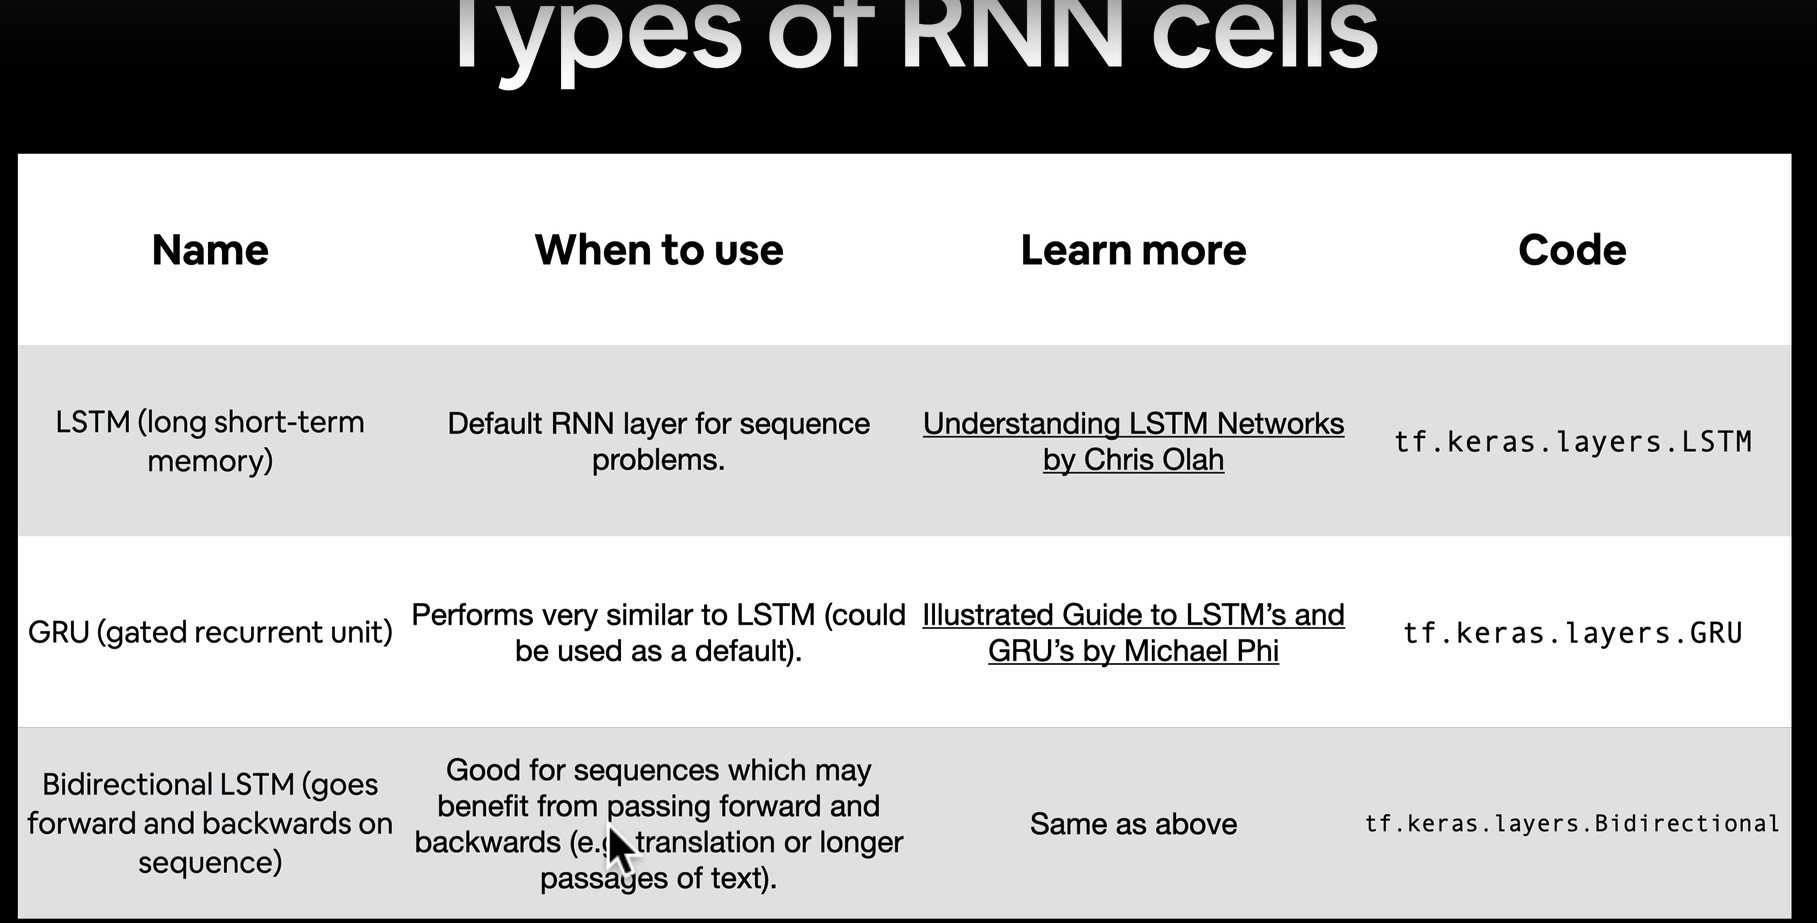

# Model 5 ": Conv1D

In [84]:
inputs = tf.keras.Input(shape = (1,), dtype = tf.string, name = 'input_layer')

x = text_tokenizer(inputs)

x = embedding(x)

x = layers.Conv1D(filters = 64, kernel_size = 5, strides = 1, padding = 'valid', activation = 'relu')(x)

x = layers.GlobalMaxPool1D()(x)

outputs = layers.Dense(units = 1, activation = 'sigmoid')(x)

model_5 = tf.keras.Model(inputs,outputs, name = 'model_5_Conv1D')

model_5.compile(loss = 'binary_crossentropy',
                optimizer = Adam(),
                metrics = ['accuracy'])

history_5 = model_5.fit(train_sentance,
                        train_label,
                        epochs = 5,
                        validation_data = [val_sentance,val_label],
                        callbacks = [create_tensorboard_callback(SAVE_DIR,
                                                                 'model_5_Conv1D')])

Saving TensorBoard log files to: model_logs/model_5_Conv1D/20230226-163009
Epoch 1/5
215/215 [==============================] - 6s 23ms/step - loss: 0.1158 - accuracy: 0.9635 - val_loss: 0.9994 - val_accuracy: 0.7651
Epoch 2/5
215/215 [==============================] - 4s 17ms/step - loss: 0.0719 - accuracy: 0.9724 - val_loss: 1.1129 - val_accuracy: 0.7585
Epoch 3/5
215/215 [==============================] - 4s 17ms/step - loss: 0.0591 - accuracy: 0.9756 - val_loss: 1.1981 - val_accuracy: 0.7625
Epoch 4/5
215/215 [==============================] - 5s 21ms/step - loss: 0.0561 - accuracy: 0.9785 - val_loss: 1.2995 - val_accuracy: 0.7454
Epoch 5/5
215/215 [==============================] - 4s 19ms/step - loss: 0.0495 - accuracy: 0.9787 - val_loss: 1.3645 - val_accuracy: 0.7375


In [85]:
pred_5_prob = model_5.predict(val_sentance)
pred_5_prob[:10]

24/24 [==============================] - 0s 3ms/step


array([[6.8460702e-04],
       [6.2924242e-01],
       [9.5226765e-01],
       [9.9104956e-02],
       [9.9999237e-01],
       [1.0222105e-02],
       [4.8117340e-01],
       [3.5624234e-05],
       [9.9973488e-01],
       [9.9999410e-01]], dtype=float32)

In [86]:
pred_5 = tf.squeeze(tf.round(pred_5_prob))
pred_5[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 1., 0., 0., 0., 1., 1.], dtype=float32)>

In [87]:
result_5 = calculate_results(y_true = val_label, y_pred = pred_5)
result_5

{'accuracy': 0.7375328083989501,
 'precision': 0.7395338246495916,
 'recall': 0.7375328083989501,
 'f1': 0.7382080359602714}

# Model 6 : Transfer Learning on NLP from tfhub.dev

using - `USE` - `Universal Sentance Encoder` - https://tfhub.dev/google/universal-sentence-encoder/4

- The model / encoder directly inputs the text and output a feature vector of size (512,)

In [88]:
import tensorflow_hub as hub

In [89]:
use_encoder_layer = hub.KerasLayer(handle = 'https://tfhub.dev/google/universal-sentence-encoder/4',
                                   trainable = False, # we are not trainiung any of the layers of the pre-trained model for now.
                                   dtype = tf.string,
                                   input_shape = []) # the universal sentance encoder is taken any varibale shapes handle by the model itself

In [90]:
from tensorflow.keras.models import Sequential

In [91]:
# create the model_6

model_6 = Sequential([
    use_encoder_layer, # takes the text of any length and outputs a feature vector of 512 dimentions
    layers.Dense(units = 64, activation = 'relu'),
    layers.Dense(units = 1, activation = 'sigmoid')
], name = 'model_6_use_full_data')

model_6.compile(loss = 'binary_crossentropy',
                optimizer = Adam(),
                metrics = ['accuracy'])

history_6 = model_6.fit(train_sentance,
                        train_label,
                        epochs = 5,
                        validation_data = (val_sentance, val_label),
                        callbacks = [create_tensorboard_callback(SAVE_DIR,'model_6_use_1')])

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


Saving TensorBoard log files to: model_logs/model_6_use_1/20230226-163109
Epoch 1/5
215/215 [==============================] - 7s 19ms/step - loss: 0.5097 - accuracy: 0.7762 - val_loss: 0.4368 - val_accuracy: 0.7979
Epoch 2/5
215/215 [==============================] - 2s 11ms/step - loss: 0.4184 - accuracy: 0.8102 - val_loss: 0.4206 - val_accuracy: 0.8058
Epoch 3/5
215/215 [==============================] - 2s 11ms/step - loss: 0.4040 - accuracy: 0.8212 - val_loss: 0.4128 - val_accuracy: 0.8123
Epoch 4/5
215/215 [==============================] - 2s 11ms/step - loss: 0.3940 - accuracy: 0.8269 - val_loss: 0.4139 - val_accuracy: 0.8163
Epoch 5/5
215/215 [==============================] - 3s 13ms/step - loss: 0.3874 - accuracy: 0.8279 - val_loss: 0.4125 - val_accuracy: 0.8136


In [92]:
pred_6_prob = model_6.predict(val_sentance)
pred_6_prob[:10]

24/24 [==============================] - 1s 9ms/step


array([[0.04797211],
       [0.13535571],
       [0.8535743 ],
       [0.48518568],
       [0.9942114 ],
       [0.9177624 ],
       [0.12720267],
       [0.7179403 ],
       [0.9560963 ],
       [0.7083708 ]], dtype=float32)

In [93]:
pred_6 = tf.squeeze(tf.round(pred_6_prob))
pred_6[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 0., 1., 0., 1., 1., 0., 1., 1., 1.], dtype=float32)>

In [94]:
result_6 = calculate_results(y_true = val_label, y_pred = pred_6)
result_6

{'accuracy': 0.8136482939632546,
 'precision': 0.8131056406723903,
 'recall': 0.8136482939632546,
 'f1': 0.8128028319998795}

# Transfer Learning with 10% of the data

In [95]:
train_sentance[:10]

array(['BBC News - India rail crash: Trains derail in Madhya Pradesh flash flood http://t.co/wmUTCDG36b',
       '@Ohmygoshi @unsuckdcmetro At this point I expect to hear reports about a Metrobus being derailed.',
       'Cramer: 3 words that wrecked DIS stock - http://t.co/ud7XObYUa1',
       "China's Stock Market Crash: Are There Gems In The Rubble? http://t.co/o6oNSjHCsD #tcot #p2 #news",
       'Heard theres two more deaths and a murder chrissie kills adam?  val and finn die? #emmerdale',
       'what if i want to fuck the duck until explode. it could be greasy',
       "When you lowkey already know you're gonna drown in school this year :) http://t.co/aCMrm833zq",
       "@Bilsko and suddenly I'm inundated with research. @humofthecity",
       'you wrecked my whole world',
       'Helping Hand: In Mumbai 2 TTEs take charge of helpline to calm anxious relatives - The Indian Exp... http://t.co/B9KUylcxg4 MumbaiTimes'],
      dtype=object)

In [96]:
train_label[:10]

array([1, 1, 0, 0, 0, 0, 0, 1, 0, 1])

In [97]:
len_train_sentance = len(train_sentance)
len_10_percent = int(0.1*len_train_sentance)
len_10_percent

685

In [98]:
train_sentance_10_percent = train_sentance[:len_10_percent]

train_label_10_percent = train_label[:len_10_percent]

In [99]:
pd.Series(train_label_10_percent).value_counts()

0    403
1    282
dtype: int64

In [100]:
# create the model_6

model_7 = Sequential([
    use_encoder_layer, # takes the text of any length and outputs a feature vector of 512 dimentions
    layers.Dense(units = 64, activation = 'relu'),
    layers.Dense(units = 1, activation = 'sigmoid')
], name = 'model_7_use_10_percent')

model_7.compile(loss = 'binary_crossentropy',
                optimizer = Adam(),
                metrics = ['accuracy'])

history_7 = model_7.fit(train_sentance_10_percent,
                        train_label_10_percent,
                        epochs = 5,
                        validation_data = (val_sentance, val_label),
                        callbacks = [create_tensorboard_callback(SAVE_DIR,'model_7_use_10_percent')])

Saving TensorBoard log files to: model_logs/model_7_use_10_percent/20230226-163133
Epoch 1/5
22/22 [==============================] - 3s 50ms/step - loss: 0.6707 - accuracy: 0.6978 - val_loss: 0.6464 - val_accuracy: 0.7690
Epoch 2/5
22/22 [==============================] - 1s 26ms/step - loss: 0.6066 - accuracy: 0.8044 - val_loss: 0.5884 - val_accuracy: 0.7769
Epoch 3/5
22/22 [==============================] - 1s 26ms/step - loss: 0.5322 - accuracy: 0.8175 - val_loss: 0.5298 - val_accuracy: 0.7717
Epoch 4/5
22/22 [==============================] - 1s 45ms/step - loss: 0.4686 - accuracy: 0.8175 - val_loss: 0.4925 - val_accuracy: 0.7717
Epoch 5/5
22/22 [==============================] - 1s 39ms/step - loss: 0.4272 - accuracy: 0.8248 - val_loss: 0.4717 - val_accuracy: 0.7769


In [101]:
pred_7_prob = model_7.predict(val_sentance)
pred_7_prob[:10]

24/24 [==============================] - 1s 9ms/step


array([[0.07824083],
       [0.2684066 ],
       [0.49600658],
       [0.49169794],
       [0.9050253 ],
       [0.71462756],
       [0.25360975],
       [0.59152925],
       [0.85751235],
       [0.8071288 ]], dtype=float32)

In [102]:
pred_7 = tf.squeeze(tf.round(pred_7_prob))
pred_7[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 0., 0., 0., 1., 1., 0., 1., 1., 1.], dtype=float32)>

In [103]:
result_7 = calculate_results(y_true = val_label, y_pred = pred_7)
result_7

{'accuracy': 0.7769028871391076,
 'precision': 0.7769028871391076,
 'recall': 0.7769028871391076,
 'f1': 0.7769028871391076}

In [104]:
result_6

{'accuracy': 0.8136482939632546,
 'precision': 0.8131056406723903,
 'recall': 0.8136482939632546,
 'f1': 0.8128028319998795}

# Comparing the results of all the models

In [105]:
model_1.name

'model_1'

In [106]:
all_results = pd.DataFrame({'baseline':result_0,
                            model_1.name : result_1,
                            model_2.name : result_2,
                            model_3.name : result_3,
                            model_4.name : result_4,
                            model_5.name : result_5,
                            model_6.name : result_6,
                            model_7.name : result_7})

all_results

,baseline,model_1,model_2_LSTM,model_3_GRU,model_4_bidirectional,model_5_Conv1D,model_6_use_full_data,model_7_use_10_percent
accuracy,0.813648,0.803150,0.772966,0.759843,0.772966,0.737533,0.813648,0.776903
precision,0.825231,0.803070,0.772276,0.759753,0.771978,0.739534,0.813106,0.776903
recall,0.813648,0.803150,0.772966,0.759843,0.772966,0.737533,0.813648,0.776903
f1,0.807923,0.801454,0.770937,0.759796,0.771752,0.738208,0.812803,0.776903


In [107]:
all_results = all_results.transpose()
all_results

,accuracy,precision,recall,f1
baseline,0.813648,0.825231,0.813648,0.807923
model_1,0.803150,0.803070,0.803150,0.801454
model_2_LSTM,0.772966,0.772276,0.772966,0.770937
model_3_GRU,0.759843,0.759753,0.759843,0.759796
model_4_bidirectional,0.772966,0.771978,0.772966,0.771752
model_5_Conv1D,0.737533,0.739534,0.737533,0.738208
model_6_use_full_data,0.813648,0.813106,0.813648,0.812803
model_7_use_10_percent,0.776903,0.776903,0.776903,0.776903


In [108]:
all_results.sort_values(by = 'f1', ascending = False, inplace = True)

# Lets Visualize the results

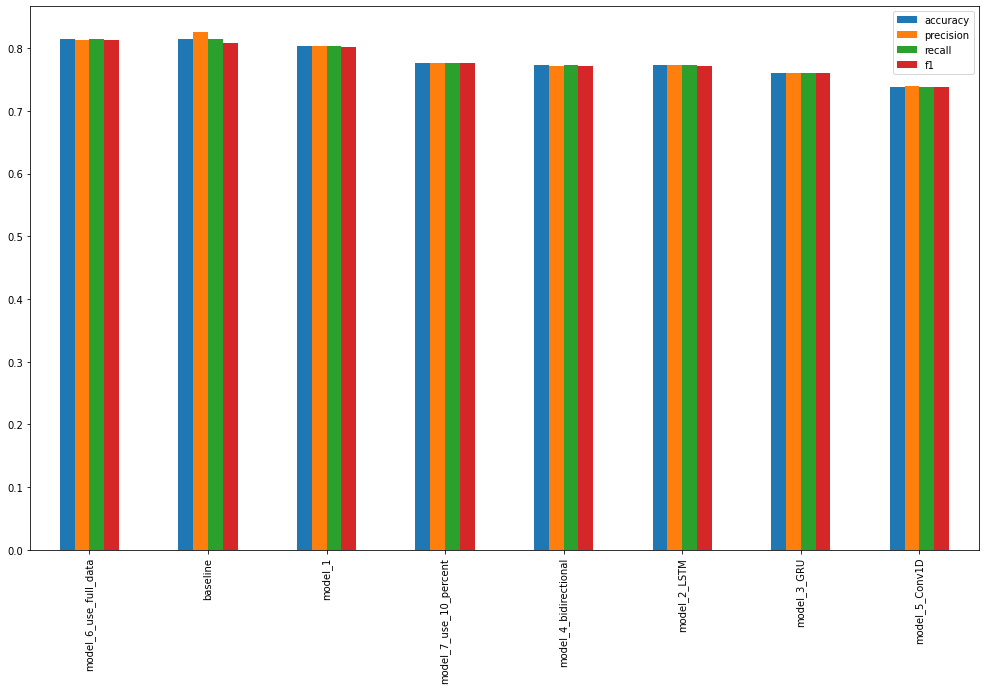

In [109]:
# lets plot all the metrics in a single plot
all_results.plot(kind = 'bar', figsize = (17,10));

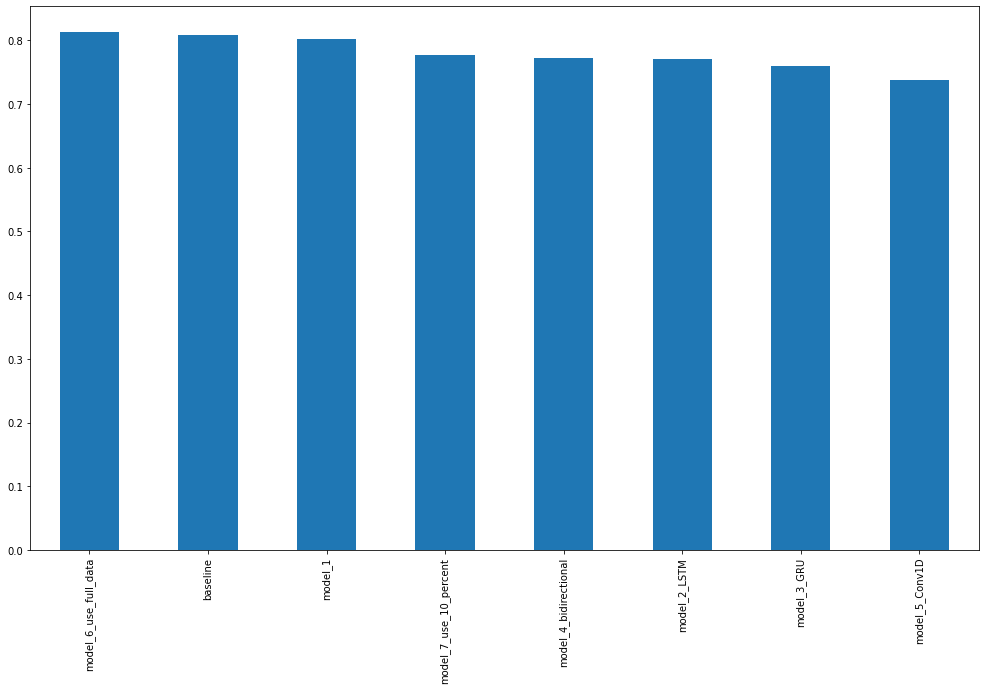

In [110]:
# plot the f1 score in a plot
all_results['f1'].plot(kind = 'bar', figsize = (17,10));

# Lets upload to the logs to Tensorboard

In [111]:
# !tensorboard dev upload \
# --logdir ./model_logs \
# --name 'NLP Fundamentals Training' \
# --name 'Model on learning tracks' \
# --one_shot

In [112]:
# !tensorboard dev list

In [113]:
# !tensorboard dev delete \
# --experiment_id KRK2JjKQQ6OT1ZVglX3eAA

In [114]:
# !tensorboard dev list

# Lets Save the model 

- Default saving mode (native to tensorflow)
- HDF5 Format, compatible model across platforms

In [115]:
# evaluate our best model

model_6.evaluate(val_sentance, val_label)

24/24 [==============================] - 0s 9ms/step - loss: 0.4125 - accuracy: 0.8136


[0.41253146529197693, 0.8136482834815979]

In [116]:
# lets save and load the model in the default native tensorflow format

model_6.save('model_6_default_format')

In [117]:
load_default_format_model = tf.keras.models.load_model('model_6_default_format')
load_default_format_model

In [118]:
load_default_format_model.evaluate(val_sentance, val_label)

24/24 [==============================] - 1s 10ms/step - loss: 0.4125 - accuracy: 0.8136


[0.41253146529197693, 0.8136482834815979]

In [119]:
# lets save and load in the HDF5 format

model_6.save('model_6.h5')

In [120]:
load_h5_format_model = tf.keras.models.load_model(filepath = 'model_6.h5',
                                                  custom_objects = {'KerasLayer' : hub.KerasLayer})

In [121]:
load_h5_format_model.evaluate(val_sentance, val_label)

24/24 [==============================] - 1s 19ms/step - loss: 0.4125 - accuracy: 0.8136


[0.41253146529197693, 0.8136482834815979]

# Lets download the save models

In [122]:
from google.colab import files

In [123]:
# files.download('model_6.h5')

In [124]:
#files.download('metadata.tsv')

In [128]:
!ls -lh

total 997M
-rw-r--r-- 1 root root  12K Feb 26 16:26 helper_functions.py
-rw-r--r-- 1 root root  79K Feb 26 16:27 metadata.tsv
drwxr-xr-x 4 root root 4.0K Feb 26 16:31 model_6_default_format
-rw-r--r-- 1 root root 981M Feb 26 16:32 model_6.h5
drwxr-xr-x 9 root root 4.0K Feb 26 16:31 model_logs
-rw-r--r-- 1 root root 594K Mar 31  2021 nlp_getting_started.zip
drwxr-xr-x 2 root root 4.0K Feb 26 16:26 __pycache__
drwxr-xr-x 1 root root 4.0K Feb 23 14:38 sample_data
-rw-r--r-- 1 root root  23K Feb 26 16:26 sample_submission.csv
-rw-r--r-- 1 root root 411K Feb 26 16:26 test.csv
-rw-r--r-- 1 root root 965K Feb 26 16:26 train.csv
-rw-r--r-- 1 root root  15M Feb 26 16:27 vectors.tsv


> Lets see the size comparison of the model which is saved in the memery

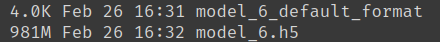

copyimg the saved model from terminal to the google drive

In [143]:
# copying a file from the memory to a directory

# !cp model_6.h5 '/content/drive/MyDrive/Udemy Courses - 2.0/TensorFlow Developer Certification Training/my_practice/saved_model'

In [149]:
# copying a directory to a directory - note the usage of -r along with usge of cp command in the terminal

# !cp -r model_6_default_format '/content/drive/MyDrive/Udemy Courses - 2.0/TensorFlow Developer Certification Training/my_practice/saved_model'

# Lets inspect on the most wrong predictions

In [150]:
# lets create a dataframe on on the validation set

In [160]:
val_df = pd.DataFrame({'text': val_sentance,
                      'target':val_label,
                      'pred' : pred_6,
                      'pred_prob' : tf.squeeze(pred_6_prob)})

val_df

,text,target,pred,pred_prob
0,Maaaaan I love Love Without Tragedy by @rihann...,0,0.0,0.047972
1,?Ìü New Ladies Shoulder Tote #Handbag Faux Lea...,0,0.0,0.135356
2,@noah_anyname That's where the concentration c...,0,1.0,0.853574
3,Sinkhole Selfies: You Wont Believe What's In T...,0,0.0,0.485186
4,California wildfires force thousands to evacua...,1,1.0,0.994211
...,...,...,...,...
757,#Newswatch: 2 vehicles collided at Lock and La...,1,1.0,0.677301
758,Spent too many hours sinking into the wonderfu...,0,0.0,0.083023
759,Real people. True stories. Real pain &amp; suf...,1,1.0,0.757554
760,kabwandi_: Breaking news! Unconfirmed! I just ...,0,1.0,0.533217


In [161]:
wrong_df = val_df[val_df['target'] != val_df['pred']].sort_values(by = 'pred_prob', ascending = False).reset_index(drop = True)

wrong_df[:10]

,text,target,pred,pred_prob
0,#hot C-130 specially modified to land in a st...,0,1.0,0.974277
1,Episcopal priests on road trip with interracia...,0,1.0,0.962205
2,Weapons stolen from National Guard Armory in N...,0,1.0,0.917762
3,? High Skies - Burning Buildings ? http://t.co...,0,1.0,0.903640
4,09:13 PM: Hazardous Weather Outlook (http://t...,0,1.0,0.888403
5,One thing you can be sure of. There will never...,0,1.0,0.879212
6,Pretty much every time the audio dies on an au...,0,1.0,0.867590
7,RT '@NASASolarSystem: Jupiter's Red Spot is a ...,0,1.0,0.866304
8,A protest rally at Stone Mountain? Atleast the...,0,1.0,0.859313
9,@noah_anyname That's where the concentration c...,0,1.0,0.853574


In [162]:
top_10_false_poitives = wrong_df[:10]
top_10_false_poitives

,text,target,pred,pred_prob
0,#hot C-130 specially modified to land in a st...,0,1.0,0.974277
1,Episcopal priests on road trip with interracia...,0,1.0,0.962205
2,Weapons stolen from National Guard Armory in N...,0,1.0,0.917762
3,? High Skies - Burning Buildings ? http://t.co...,0,1.0,0.903640
4,09:13 PM: Hazardous Weather Outlook (http://t...,0,1.0,0.888403
5,One thing you can be sure of. There will never...,0,1.0,0.879212
6,Pretty much every time the audio dies on an au...,0,1.0,0.867590
7,RT '@NASASolarSystem: Jupiter's Red Spot is a ...,0,1.0,0.866304
8,A protest rally at Stone Mountain? Atleast the...,0,1.0,0.859313
9,@noah_anyname That's where the concentration c...,0,1.0,0.853574


In [163]:
top_10_false_negatives = wrong_df[-10:]
top_10_false_negatives

,text,target,pred,pred_prob
132,@allen_enbot If you mess up it's gonna explode...,1,0.0,0.069207
133,going to redo my nails and watch behind the sc...,1,0.0,0.060631
134,@leedsrouge Love what you picked! We're playin...,1,0.0,0.054097
135,One Direction Is my pick for http://t.co/q2eBl...,1,0.0,0.049198
136,I liked a @YouTube video http://t.co/43sXG9Z6x...,1,0.0,0.047575
137,@blakeshelton DON'T be a FART ??in a WINDSTORM...,1,0.0,0.046633
138,#hiphop #news #indie Apollo Brown ÛÒ ÛÏDeton...,1,0.0,0.045073
139,This is set to become a huge one month wonder....,1,0.0,0.037703
140,Oh the usual. Mass murder and world domination...,1,0.0,0.026222
141,ÛÏ@LordBrathwaite: Everyone Here: Ahh I hate ...,1,0.0,0.022630


In [188]:
# Lets inspect in a prettier format for the top10 false positives

print('Top10 False Postives (predicting dissater when it should be not)')

for ind in top_10_false_poitives.index:
  text = top_10_false_poitives.loc[ind]['text']
  pred = top_10_false_poitives.loc[ind]['pred']
  pred_prob = top_10_false_poitives.loc[ind]['pred_prob']
  
  print(f'\n{text}')
  print(f'\n{pred_prob:.2f}\n')
  print('........')


Top10 False Postives (predicting dissater when it should be not)

#hot  C-130 specially modified to land in a stadium and rescue hostages in Iran in 1980 http://t.co/zY3hpdJNwg #prebreak #best

0.97

........

Episcopal priests on road trip with interracial family shares harrowing story of police harassment http://t.co/RG4JIsHyBs via @dailykos

0.96

........

Weapons stolen from National Guard Armory in New Albany still missing #Gunsense http://t.co/lKNU8902JE

0.92

........

? High Skies - Burning Buildings ? http://t.co/uVq41i3Kx2 #nowplaying

0.90

........

09:13 PM:  Hazardous Weather Outlook (http://t.co/ed1VpITsWY): NO HAZARDOUS WEATHER IS EXPECTED AT THIS TIME.... http://t.co/6XSbddlZiy

0.89

........

One thing you can be sure of. There will never be bush fires in Scotland as the ground is always soaking wet????

0.88

........

Pretty much every time the audio dies on an audio stream for a baseball game I assume catastrophic nuclear attack.

0.87

........

RT '@NASASolarS

In [190]:
# Lets inspect in a prettier format for the top10 false negative

print('Top10 False Negatives (predicting not disaster when it should be)')

for ind in top_10_false_negatives.index:

  text = top_10_false_negatives.loc[132]['text']
  pred = top_10_false_negatives.loc[132]['pred']
  pred_prob = top_10_false_negatives.loc[132]['pred_prob']
  
  print(f'\n{text}')
  print(f'\n{pred_prob:.2f}\n')
  print('........')


Top10 False Negatives (predicting not disaster when it should be)

@allen_enbot If you mess up it's gonna explode...

0.07

........

@allen_enbot If you mess up it's gonna explode...

0.07

........

@allen_enbot If you mess up it's gonna explode...

0.07

........

@allen_enbot If you mess up it's gonna explode...

0.07

........

@allen_enbot If you mess up it's gonna explode...

0.07

........

@allen_enbot If you mess up it's gonna explode...

0.07

........

@allen_enbot If you mess up it's gonna explode...

0.07

........

@allen_enbot If you mess up it's gonna explode...

0.07

........

@allen_enbot If you mess up it's gonna explode...

0.07

........

@allen_enbot If you mess up it's gonna explode...

0.07

........
